# Import Libraries

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import TimeSeriesDifferentiator
from sklearn.metrics import mean_absolute_error

/Users/ikeryanez/anaconda3/envs/tfm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Data

In [2]:
df = pd.read_csv('../../data/df_no24.csv')
df.head()

,Unnamed: 0,date,sp500,cpi,nasdaq,gdp,unrate,usdeur,usdgbp
0,0,2014-02-18,1840.760010,235.547,3675.0,17197.738,6.7,0.72993,0.59661
1,1,2014-02-19,1828.750000,235.547,3654.5,17197.738,6.7,0.72969,0.59809
2,2,2014-02-20,1839.780029,235.547,3671.5,17197.738,6.7,0.72664,0.59930
3,3,2014-02-21,1836.250000,235.547,3664.5,17197.738,6.7,0.72831,0.59967
4,4,2014-02-24,1847.609985,235.547,3688.0,17197.738,6.7,0.72880,0.60018


In [3]:
data = df[['date', 'sp500', 'cpi', 'nasdaq', 'gdp', 'unrate', 'usdeur', 'usdgbp']] 
data.head()

,date,sp500,cpi,nasdaq,gdp,unrate,usdeur,usdgbp
0,2014-02-18,1840.760010,235.547,3675.0,17197.738,6.7,0.72993,0.59661
1,2014-02-19,1828.750000,235.547,3654.5,17197.738,6.7,0.72969,0.59809
2,2014-02-20,1839.780029,235.547,3671.5,17197.738,6.7,0.72664,0.59930
3,2014-02-21,1836.250000,235.547,3664.5,17197.738,6.7,0.72831,0.59967
4,2014-02-24,1847.609985,235.547,3688.0,17197.738,6.7,0.72880,0.60018


In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('D')
data = data['nasdaq']
#data = data.sort_index()
data.head(20)

/var/folders/cp/8x9lqtyj66dc8l1337z6dk180000gn/T/ipykernel_2854/1347842086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')


date
2014-02-18    3675.00
2014-02-19    3654.50
2014-02-20    3671.50
2014-02-21    3664.50
2014-02-22        NaN
2014-02-23        NaN
2014-02-24    3688.00
2014-02-25    3688.50
2014-02-26    3673.75
2014-02-27    3701.50
2014-02-28    3695.25
2014-03-01        NaN
2014-03-02        NaN
2014-03-03    3668.75
2014-03-04    3716.75
2014-03-05    3728.25
2014-03-06    3722.00
2014-03-07    3704.25
2014-03-08        NaN
2014-03-09        NaN
Freq: D, Name: nasdaq, dtype: float64

In [5]:
data.fillna(method='ffill', inplace=True, limit=None, axis=None, downcast=None)
data.head(20)


/var/folders/cp/8x9lqtyj66dc8l1337z6dk180000gn/T/ipykernel_2854/2751184104.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True, limit=None, axis=None, downcast=None)
/var/folders/cp/8x9lqtyj66dc8l1337z6dk180000gn/T/ipykernel_2854/2751184104.py:1: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  data.fillna(method='ffill', inplace=True, limit=None, axis=None, downcast=None)


date
2014-02-18    3675.00
2014-02-19    3654.50
2014-02-20    3671.50
2014-02-21    3664.50
2014-02-22    3664.50
2014-02-23    3664.50
2014-02-24    3688.00
2014-02-25    3688.50
2014-02-26    3673.75
2014-02-27    3701.50
2014-02-28    3695.25
2014-03-01    3695.25
2014-03-02    3695.25
2014-03-03    3668.75
2014-03-04    3716.75
2014-03-05    3728.25
2014-03-06    3722.00
2014-03-07    3704.25
2014-03-08    3704.25
2014-03-09    3704.25
Freq: D, Name: nasdaq, dtype: float64

In [6]:
# Data differentiated
# ==============================================================================
diferenciator = TimeSeriesDifferentiator(order=1)
data_diff = diferenciator.fit_transform(data)
data_diff = pd.Series(data_diff, index=data.index).dropna()
data_diff.head(4)

/Users/ikeryanez/anaconda3/envs/tfm/lib/python3.10/site-packages/skforecast/preprocessing/preprocessing.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.initial_values.append(X[0])
/Users/ikeryanez/anaconda3/envs/tfm/lib/python3.10/site-packages/skforecast/preprocessing/preprocessing.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.last_values.append(X[-1])


date
2014-02-19   -20.5
2014-02-20    17.0
2014-02-21    -7.0
2014-02-22     0.0
Freq: D, dtype: float64

Train dates : 2014-02-18 00:00:00 --- 2021-01-01 00:00:00  (n=2510)
Test dates  : 2021-01-01 00:00:00 --- 2023-12-29 00:00:00  (n=1093)


Text(0.5, 1.0, 'Differentiated data')

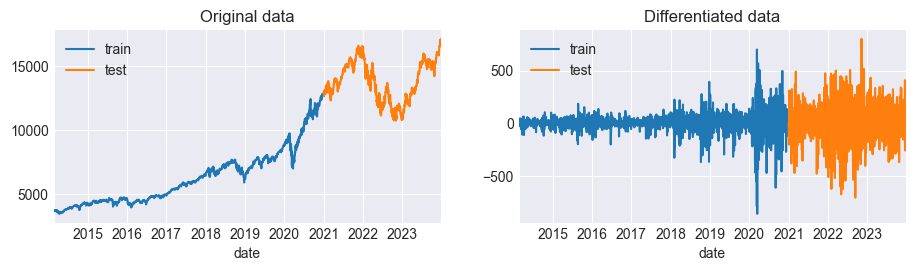

In [7]:
# Data partition train-test
# ==============================================================================
end_train = '2021-01-01'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(11, 2.5))
axs = axs.ravel()
data.loc[:end_train].plot(ax=axs[0], label='train')
data.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Original data')

data_diff.loc[:end_train].plot(ax=axs[1], label='train')
data_diff.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Differentiated data')

Error (MAE) Random Forest: 1524.89
Error (MAE) Gradient Boosting: 1529.46


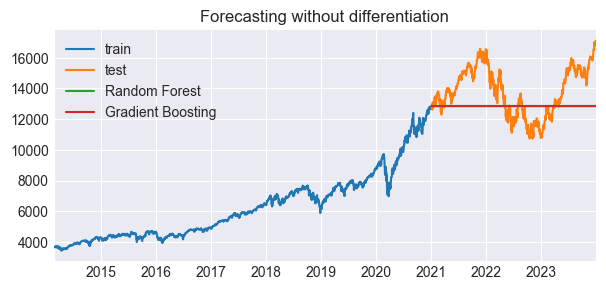

In [8]:
# Forecasting without differentiation
# ==============================================================================
steps = len(data.loc[end_train:])

# Forecasters
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 12
                )
forecaster_gb = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=963),
                    lags      = 12
                )

# Train
forecaster_rf.fit(data.loc[:end_train])
forecaster_gb.fit(data.loc[:end_train])

# Predict
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)

# Error
error_rf = mean_absolute_error(data.loc[end_train:], predictions_rf)
error_gb = mean_absolute_error(data.loc[end_train:], predictions_gb)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")
print(f"Error (MAE) Gradient Boosting: {error_gb:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_gb.plot(ax=ax, label='Gradient Boosting')
ax.set_title(f'Forecasting without differentiation')
ax.set_xlabel('')
ax.legend()

Error (MAE) Random Forest: 1530.18
Error (MAE) Gradient Boosting: 2002.51


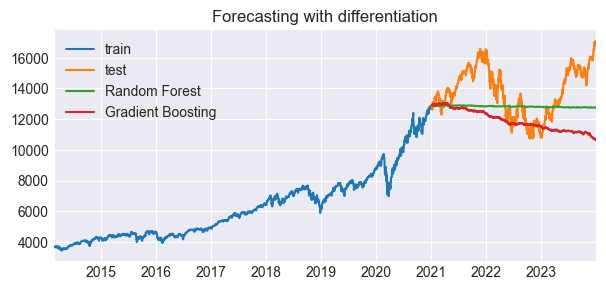

In [9]:
# Forecasting with differentiation
# ==============================================================================
steps = len(data.loc[end_train:])

# Forecasters
forecaster_rf = ForecasterAutoreg(
                    regressor       = RandomForestRegressor(random_state=963),
                    lags            = 12,
                    differentiation = 1
                )
forecaster_gb = ForecasterAutoreg(
                    regressor       = XGBRegressor(random_state=963),
                    lags            = 12,
                    differentiation = 1
                )

# Train
forecaster_rf.fit(data.loc[:end_train])
forecaster_gb.fit(data.loc[:end_train])

# Predict
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)

# Error
error_rf = mean_absolute_error(data.loc[end_train:], predictions_rf)
error_gb = mean_absolute_error(data.loc[end_train:], predictions_gb)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")
print(f"Error (MAE) Gradient Boosting: {error_gb:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_gb.plot(ax=ax, label='Gradient Boosting')
ax.set_title(f'Forecasting with differentiation')
ax.set_xlabel('')
ax.legend();